## Reading and plotting LMA data

In [a previous module we learned about LMA VHF source files](./LMAsourcefiles.ipynb) - their structure, and principles of data quality control using the station mask and $\chi_{\nu}^2$.

We'll use the [xlma-python package](https://github.com/deeplycloudy/xlma-python/) to read, process, and visualize the data in these files.

We'll start by importing some libraries and reading a file. In fact, we can read more than Replace the filename below with a file of interest to you, if you want.

In [1]:
# We could tediously build a list …
# filenames = ['/data/Houston/realtime-tracer/LYLOUT_200524_210000_0600.dat.gz',]

# Instead, let's read a couple hours at the same time.
import sys, glob
filenames = glob.glob('/data/Houston/130619/LYLOUT_130619_2[0-1]*.dat.gz')
for filename in filenames:
    print(filename)

/data/Houston/130619/LYLOUT_130619_213000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_201000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_214000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_215000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_200000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_212000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_205000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_210000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_202000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_203000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_211000_0600.dat.gz
/data/Houston/130619/LYLOUT_130619_204000_0600.dat.gz


In [2]:
import glob
import numpy as np
import datetime
import xarray as xr
import pyproj as proj4

from pyxlma.lmalib.io import read as lma_read

In [3]:
lma_data, starttime = lma_read.dataset(filenames)

## Investigating the `pyxlma` data structure

We just read in the data from a list of filenames, and got back an `lma_data` variable, and a `starttime`. What's in these variables?

`starttime` is a Python datetime object, with helps us do math operations on times instead of multiplying by 60 and 24 ourselves.

In [4]:
# Should match what we expect from the filenames
print(starttime)
print(type(starttime))

2013-06-19 20:00:00
<class 'datetime.datetime'>


`lma_data` is an [`xarray` object](https://xarray.pydata.org). If we print it, we see that it looks much like a NetCDF file, with dimensions and variables that allow us to store whole arrays of data and give them names. `xarray` is the best way to look at NetCDF data in Python.

(If you'd like to learn more about `xarray` and NetCDF, you can check out [Unidata's lessons on xarray and NetCDF](https://unidata.github.io/python-training/workshop/workshop-intro/).)

In [5]:
print(lma_data)

<xarray.Dataset>
Dimensions:                      (number_of_events: 462745, number_of_stations: 13)
Dimensions without coordinates: number_of_events, number_of_stations
Data variables:
    network_center_latitude      float64 29.76
    network_center_longitude     float64 -95.37
    network_center_altitude      float64 -200.0
    station_latitude             (number_of_stations) float32 29.939247 ... 2...
    station_longitude            (number_of_stations) float32 -95.64618 ... -...
    station_altitude             (number_of_stations) float32 31.660002 ... -...
    station_event_fraction       (number_of_stations) float32 37154.082 ... 0.0
    station_power_ratio          (number_of_stations) float32 1.0208333 ... 0.0
    event_latitude               (number_of_events) float32 29.54482 ... 31.3...
    event_longitude              (number_of_events) float32 -95.14241 ... -93...
    event_altitude               (number_of_events) float32 7202.98 ... 7595.08
    event_time            

There are a few things to notice above.
- The dimensions tell us how many events and stations we had in our data file.
- Some other header info about the network location and the `lma_analysis` command is included.
- There are varaibles with dimension `number_of_stations` that give the data from the station data tables.
- There are varaibles with dimension `number_of_events`, including many we'd expect.
    - Event location and time
    - `event_chi2` for the $\chi_{\nu}^2$ as given in the file.
    - `event_stations` has been calculated for us from `event_mask`. That's helpful!
    - Each event has been tagged with a unique `event_id`
    
These variables are easy to access by name - for example, we can get a nice display of 

In [6]:
print(type(lma_data.event_longitude))
lma_data.event_longitude

<class 'xarray.core.dataarray.DataArray'>


<xarray.DataArray 'event_longitude' (number_of_events: 462745)>
array([-95.14241, -95.13846, -95.782  , ..., -94.91941, -94.965  ,
       -93.02855], dtype=float32)
Dimensions without coordinates: number_of_events
Attributes:
    _FillValue:     nan
    valid_range:    [-180.0, 180.0]
    units:          degrees_east
    standard_name:  longitude
    long_name:      Longitude of event

Notice that this `xarray DataArray` variable is not only the data values, but some other metadata, such as the units and the standard variable name from the [Climate and Forecast Metadata Conventions](https://cfconventions.org). We can access those attributes if we want them:

In [7]:
print(lma_data.event_longitude.attrs['standard_name'])

longitude


## Simple plotting and filtering

`xarray` has some nice, built-in plotting functions for quickly looking at data. We'll make even nicer plots in a bit!

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

In [9]:
lma_data.plot.scatter?

Signature: lma_data.plot.scatter(x, y, ax, **kwargs)
Docstring:
Scatter Dataset data variables against each other.


Parameters
----------

ds : Dataset
x, y : str
    Variable names for x, y axis.
hue: str, optional
    Variable by which to color scattered points
hue_style: str, optional
    Can be either 'discrete' (legend) or 'continuous' (color bar).
markersize: str, optional
    scatter only. Variable by which to vary size of scattered points.
size_norm: optional
    Either None or 'Norm' instance to normalize the 'markersize' variable.
add_guide: bool, optional
    Add a guide that depends on hue_style
        - for "discrete", build a legend.
          This is the default for non-numeric `hue` variables.
        - for "continuous",  build a colorbar
row : str, optional
    If passed, make row faceted plots on this dimension name
col : str, optional
    If passed, make column faceted plots on this dimension name
col_wrap : int, optional
    Use together with ``col`` to wrap facet

We have lots of data in the file; let's grab the first 10000 points to make the plotting faster.

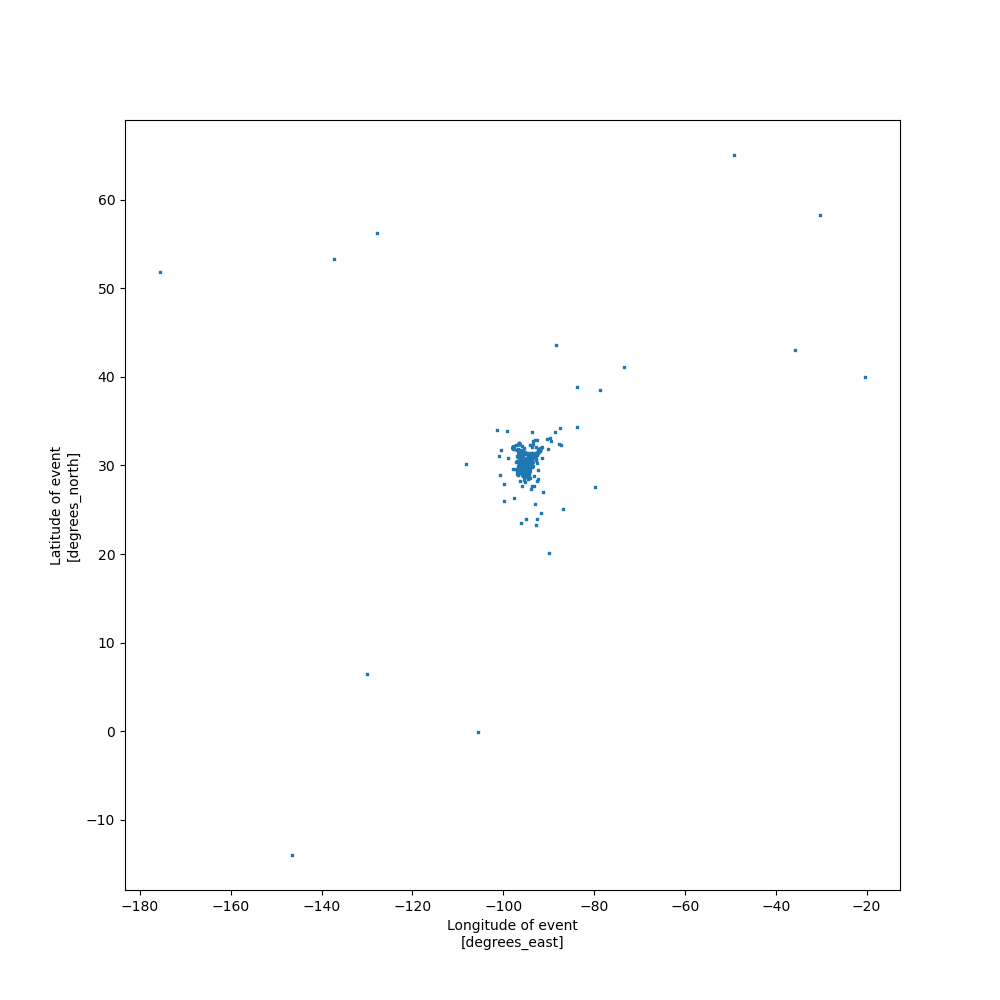

In [10]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
count_subset = {'number_of_events':slice(0,10000)}
art = lma_data[count_subset].plot.scatter('event_longitude', 'event_latitude', ax=axes,
                      s=4, marker='s', #hue='event_time', 
                     )

Looks pretty noisy. Let's try again, but filter to lower `chi2` and greater `event_contributing_stations`.

Suggested activity: adjust the station and $\chi^2$ criteria to see how the noisiness changes. As noted in earlier lessons, some experimentation to choose the level of filtering is a very common process when working with LMA data.

You can also filter on event latitude and longitude in the same way to further zoom in, or plot other combinations of data variables.

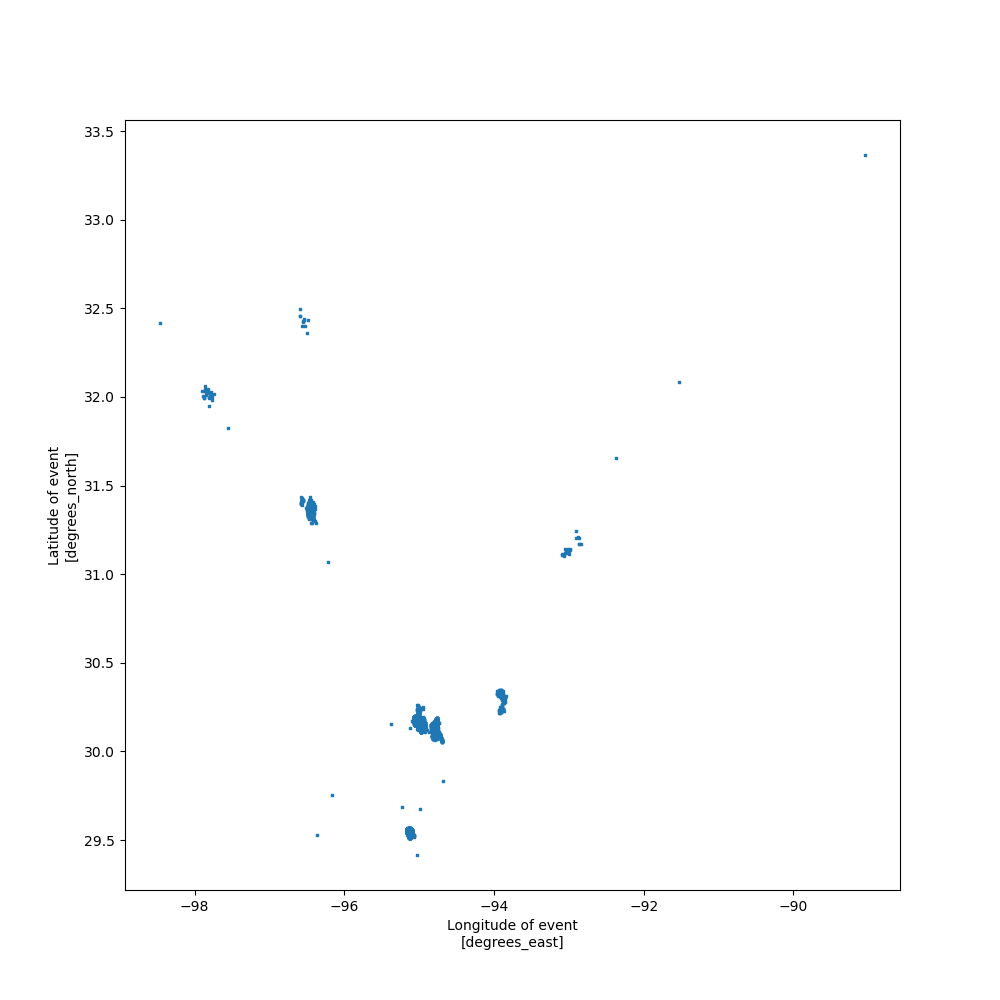

In [11]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
count_subset = {'number_of_events':slice(0,10000)}

station_filter = (lma_data.event_stations >= 6)
chi_filter = (lma_data.event_chi2 <= 1.0)
filter_subset = {'number_of_events':(chi_filter & station_filter)}

# note that we first filter on all the data select 10000 points, and then on that dataset we further filter 
art = lma_data[filter_subset][count_subset].plot.scatter('event_longitude', 'event_latitude', ax=axes,
                      s=4, marker='s', #hue='event_time', 
                     )